# Game Pace

## Goals
- develop metric to analyze the pace of play of the college hockey teams in the dataset
-Use a combination of faceoff count, goal and penalty count to get the average length of time between faceoffs.
- total game length can vary because of overtime. Use the time column in the goal tender info to get the length of each game


In [35]:
## Setup 

# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os


# Database path
db_path = os.path.join('..','data', 'db', '2023_Full_Season_Game_Stats.db')

# Load the data
conn = sqlite3.connect(db_path)

# Load table names to check path
table_names = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(table_names)

               name
0      goalie_stats
1        line_chart
2  advanced_metrics
3      game_details
4      player_stats
5         linescore
6   penalty_summary
7   scoring_summary
8  player_stats_ytd
9     master_roster


In [36]:
## Create dataframes from the needed tables
goalie_stats = pd.read_sql_query("SELECT * FROM goalie_stats", conn)

linescore = pd.read_sql_query("SELECT * FROM linescore", conn)

scoring_summary = pd.read_sql_query("SELECT * FROM scoring_summary", conn)

penalty_summary = pd.read_sql_query("SELECT * FROM penalty_summary", conn)

In [37]:
# penalties.head()

In [38]:
import re
# Standardize the time format
# Function to convert all time strings to hh:mm:ss
def standardize_time_format(minutes_str):
    # If the string is just in mm:ss format, prepend "00:"
    if re.match(r'^\d{1,2}:\d{2}$', minutes_str):
        return f"00:{minutes_str}"
    elif re.match(r'^\d{1,2}:\d{2}:\d{2}$', minutes_str):
        return minutes_str
    else:
        return f"00:00:{minutes_str}"

# Apply the function to the goalie_stats dataframe
goalie_stats['Minutes'] = goalie_stats['Minutes'].apply(standardize_time_format)

# goalie_stats.head()

In [39]:
## # get game length in seconds
def get_game_length(row):
    time = row['Minutes']
    time = time.split(':')
    return int(time[0])*60 + int(time[1]) + int(time[2])/60

goalie_stats['Game Length'] = goalie_stats.apply(get_game_length, axis=1)

goalie_stats.head()

,Team,Goalie,SV,GA,Minutes,Game_ID,Game Length
0,Lake Superior,Ethan Langenegger,32,5,00:60:00,2023-10-07-Lake Superior-Michigan State,60.000000
1,Michigan State,Trey Augustine,29,2,00:60:00,2023-10-07-Lake Superior-Michigan State,60.000000
2,Clarkson,Austin Roden,27,1,00:60:00,2023-10-07-Clarkson-Notre Dame,60.000000
3,Notre Dame,EMPTY NET,0,1,00:1:25,2023-10-07-Clarkson-Notre Dame,1.416667
4,Notre Dame,Ryan Bischel,22,2,00:58:35,2023-10-07-Clarkson-Notre Dame,58.583333


In [40]:
# Create df of game length
game_length = goalie_stats.groupby('Game_ID').agg({'Game Length': 'max'}).reset_index()

game_length.head()

,Game_ID,Game Length
0,2023-10-07-American Int'l-Massachusetts,60.00
1,2023-10-07-Augustana-Wisconsin,60.00
2,2023-10-07-Boston College-Quinnipiac,64.85
3,2023-10-07-Boston University-Bentley,63.20
4,2023-10-07-Bowling Green-Robert Morris,60.00


In [41]:
# Get the number of faceoffs for each game
# Aggregate faceoff, goal, and penalty data
faceoffs = linescore.groupby('Game_ID').apply(lambda df: df['FOW'].sum() + df['FOL'].sum())
# Divide by 2 to get the number of faceoffs (each is counted once for each team)
faceoffs /= 2
goals = scoring_summary.groupby('Game_ID').size()
penalties = penalty_summary.groupby('Game_ID').size()
# covert the series to dataframes to make merge easy
faceoffs = faceoffs.reset_index()
goals = goals.reset_index()
penalties = penalties.reset_index()

# Check the data
faceoffs.head()
goals.head()
penalties.head()

# Combine the data into a single dataframe
# Merget the faceoffs, goals, and penalties into a the game length dataframe
game_stats = pd.merge(game_length, faceoffs, on='Game_ID')
game_stats = pd.merge(game_stats, goals, on='Game_ID')
game_stats = pd.merge(game_stats, penalties, on='Game_ID')

# name the columns
game_stats.columns = ['Game_ID', 'Game_Length', 'Faceoffs', 'Goals', 'Penalties']

## calcuate the total non-goal events
game_stats['Non_Goal_Faceoffs'] = game_stats['Faceoffs'] - game_stats['Goals']

# ensure game length is datatime

# calculate the length of time between whistles for the game
game_stats['AVG_Length_of_Play'] = game_stats['Game_Length'] / game_stats['Non_Goal_Faceoffs']

# game_stats.head()
# game_stats.describe()
# game_stats.info()

# Export to TEMP folder for testing
game_stats.to_csv('../TEMP/PACE_game_stats.csv', index=False)


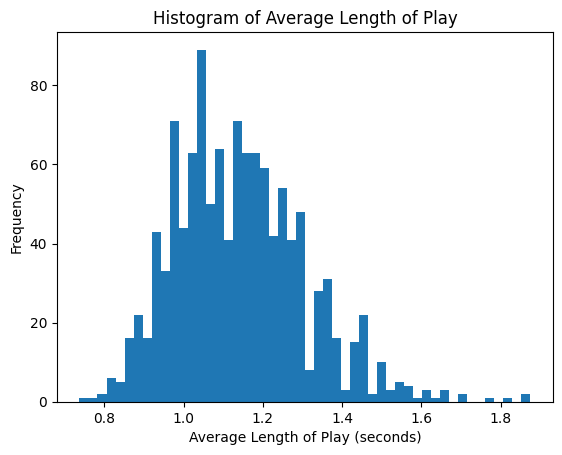

0.7374485596707819

In [43]:
## Exploratory Data Analysis

# Histogram of the average length of play
plt.hist(game_stats['AVG_Length_of_Play'], bins=50)
plt.xlabel('Average Length of Play (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Length of Play')
plt.show()

#$ Show the min
game_stats['AVG_Length_of_Play'].min()


## Aggrigate stats for each team

In [47]:
# Correct the extraction function
def extract_teams_correct(game_id):
    parts = game_id.split('-')
    return parts[3], parts[4]  # Away team first, then Home team

# Apply the corrected function
game_stats[['Away_Team', 'Home_Team']] = game_stats['Game_ID'].apply(lambda x: extract_teams_correct(x)).apply(pd.Series)

# Function to aggregate stats for a given team
def aggregate_team_stats(df, team):
    team_df = df[(df['Away_Team'] == team) | (df['Home_Team'] == team)]
    return pd.Series({
        'Games_Played': team_df.shape[0],
        'Total_Faceoffs': team_df['Faceoffs'].sum(),
        'Total_Goals': team_df['Goals'].sum(),
        'Total_Penalties': team_df['Penalties'].sum(),
        'Total_Non_Goal_Faceoffs': team_df['Non_Goal_Faceoffs'].sum(),
        'Total_Game_Length': team_df['Game_Length'].sum(),
        'Total_Play_Length': team_df['AVG_Length_of_Play'].sum(),
        'Avg_Length_of_Play': team_df['AVG_Length_of_Play'].mean()
    })

# Get the unique teams from the corrected dataset
teams_correct = pd.unique(game_stats[['Away_Team', 'Home_Team']].values.ravel('K'))

# Aggregate stats for each team using corrected function
team_stats_correct = pd.DataFrame([aggregate_team_stats(game_stats, team) for team in teams_correct], index=teams_correct)
team_stats_correct.reset_index(inplace=True)
team_stats_correct.rename(columns={'index': 'Team'}, inplace=True)

team_stats_correct.head()


,Team,Games_Played,Total_Faceoffs,Total_Goals,Total_Penalties,Total_Non_Goal_Faceoffs,Total_Game_Length,Total_Play_Length,Avg_Length_of_Play
0,American Int'l,40.0,2552.0,230.0,376.0,2322.0,2436.650000,42.723748,1.068094
1,Augustana,34.0,1952.0,195.0,269.0,1757.0,2072.000000,41.070609,1.207959
2,Boston College,41.0,2578.0,272.0,376.0,2306.0,2463.866667,44.478633,1.084845
3,Boston University,39.0,2305.0,251.0,379.0,2054.0,2373.133333,45.801352,1.174394
4,Bowling Green,36.0,2193.0,202.0,318.0,1991.0,2169.166667,39.701627,1.102823


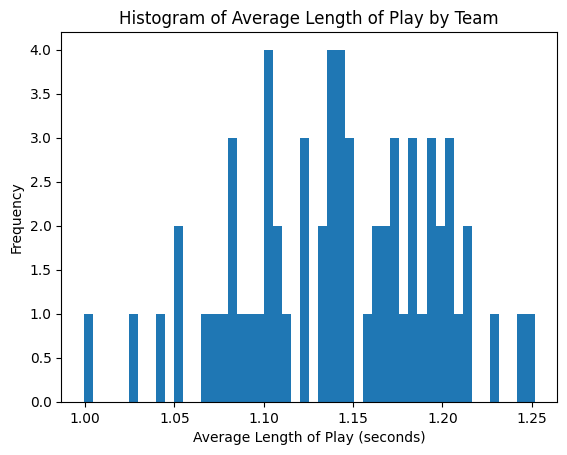

In [48]:
# Histogram of the average length of play
plt.hist(team_stats_correct['Avg_Length_of_Play'], bins=50)
plt.xlabel('Average Length of Play (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Length of Play by Team')
plt.show()